# Development Notebook for 02456: Deep Learning @ DTU
- Project 24: **Deep State Space Model for Mortality Classification using Electronic Health Records**
- Supervised by Rachael Marie De Vries (rachael.devries@bio.ku.dk)


Below is the development process for our final *SMART-M* model. Please note that this notebook must be run in colab, and there are a few lines that must be altered (filepaths etc).

More information can be found in the `readme`.


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
project_dir = '/content/drive/My Drive/ssm_ehr' # CHANGE THIS ACCORDINGLY
print(os.path.exists(project_dir))

Mounted at /content/drive
True


In [2]:
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121
!pip uninstall mamba-ssm causal-conv1d
!pip install causal-conv1d && pip install mamba-ssm

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.1/799.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# !pip uninstall torch
# !pip install torch --index-url https://download.pytorch.org/whl/cpu


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba_ssm import Mamba  # Assuming Mamba is installed
import math
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [5]:
from sklearn.metrics import average_precision_score

In [6]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding


class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes):
        """
        Args:
            ts_feature_dim (int): Number of features in time-series data (e.g., 37).
            static_feature_dim (int): Number of features in static data (e.g., 8).
            hidden_dim (int): Dimension of hidden states in the model.
            num_classes (int): Number of output classes (e.g., 2 for binary classification).
        """
        super(MambaAttentionClassifier, self).__init__()

        # Time-series processing with Mamba
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)
        self.mamba_layer = Mamba(
            d_model=ts_feature_dim,  # Include time as an additional feature
            d_state=hidden_dim,         # Mamba's internal state size
            d_conv=4,                   # Convolution width for local dependencies
            expand=2                    # Expansion factor
        )

        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm = nn.LayerNorm(hidden_dim)  # Layer normalization for stability


        # Multi-head attention
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

        # Static feature processing
        self.static_fc = nn.Linear(static_feature_dim, hidden_dim)
        self.static_norm = nn.LayerNorm(hidden_dim)

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
        """
        Args:
            ts_values (torch.Tensor): Time-series data (batch_size, seq_len, ts_feature_dim).
            ts_indicators (torch.Tensor): Indicator for missing time-series data (batch_size, seq_len, ts_feature_dim).
            ts_time (torch.Tensor): Time-series timestamps (batch_size, seq_len).
            static (torch.Tensor): Static features (batch_size, static_feature_dim).
        Returns:
            torch.Tensor: Class probabilities (batch_size, num_classes).
        """
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Handle missing data: Mask out the missing time-series values using ts_indicators
        ts_values = ts_values * ts_indicators  # Element-wise multiplication to mask missing data

        # Add time as an additional feature and apply positional encoding
        ts_time = ts_time.unsqueeze(-1)  # (batch_size, seq_len, 1)
        ts_combined = torch.cat([ts_values, ts_time], dim=-1)  # (batch_size, seq_len, ts_feature_dim + 1)
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with Mamba
        ts_encoded = self.mamba_layer(ts_combined)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.projection(ts_encoded)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.mamba_norm(ts_encoded)  # Normalize the Mamba output


        # Apply multi-head attention
        ts_encoded, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)

        # Compute attention weights
        attn_weights = F.softmax(torch.mean(ts_encoded, dim=-1, keepdim=True), dim=1)  # (batch_size, seq_len, 1)
        ts_attended = torch.sum(attn_weights * ts_encoded, dim=1)  # (batch_size, hidden_dim)

        # Process static features
        static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)
        static_encoded = self.static_norm(static_encoded)

        # Concatenate attended time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

        # Classification
        output = self.classifier(combined)  # (batch_size, num_classes)

        return output


In [7]:

class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes):
        """
        Args:
            ts_feature_dim (int): Number of features in time-series data (e.g., 37).
            static_feature_dim (int): Number of features in static data (e.g., 8).
            hidden_dim (int): Dimension of hidden states in the model.
            num_classes (int): Number of output classes (e.g., 2 for binary classification).
        """
        super(MambaAttentionClassifier, self).__init__()

        # Time-series processing with Mamba
        self.mamba_layer = Mamba(
            d_model=ts_feature_dim,  # Include time as an additional feature
            d_state=hidden_dim,         # Mamba's internal state size
            d_conv=4,                   # Convolution width for local dependencies
            expand=2                    # Expansion factor
        )

        # Static feature processing
        self.static_fc = nn.Linear(static_feature_dim, hidden_dim)

        # Attention layer to weight time-series features
        self.attention = nn.Linear(ts_feature_dim, 1)

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(ts_feature_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
      """
      Args:
          ts_values (torch.Tensor): Time-series data (batch_size, seq_len, ts_feature_dim).
          ts_indicators (torch.Tensor): Indicator for missing time-series data (batch_size, seq_len, ts_feature_dim).
          ts_time (torch.Tensor): Time-series timestamps (batch_size, seq_len).
          static (torch.Tensor): Static features (batch_size, static_feature_dim).
      Returns:
          torch.Tensor: Class probabilities (batch_size, num_classes).
      """
      # Ensure the shape of ts_indicators matches ts_values
      assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

      # Handle missing data: Mask out the missing time-series values using ts_indicators
      ts_values = ts_values * ts_indicators  # Element-wise multiplication to mask missing data

      ts_time = ts_time.unsqueeze(-1)  # (batch_size, seq_len, 1)
      ts_combined = torch.cat([ts_values, ts_time], dim=-1)  # (batch_size, seq_len, ts_feature_dim + 1)

      # Process time-series data with Mamba
      ts_encoded = self.mamba_layer(ts_combined)  # (batch_size, seq_len, hidden_dim)

      # print('ts_encoded shape',ts_encoded.shape)

      # Reshape ts_encoded for the attention layer
      batch_size, seq_len, hidden_dim = ts_encoded.shape
      ts_encoded_flat = ts_encoded.view(-1, hidden_dim)  # Flatten to (batch_size * seq_len, hidden_dim)

      # Compute attention scores
      attn_scores = self.attention(ts_encoded_flat)  # (batch_size * seq_len, 1)
      attn_scores = attn_scores.view(batch_size, seq_len, 1)  # Reshape back to (batch_size, seq_len, 1)

      # Compute attention weights
      attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len, 1)

      # Apply attention weights to the Mamba output
      ts_attended = torch.sum(attn_weights * ts_encoded, dim=1)  # (batch_size, hidden_dim)

      # Process static features
      static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)

      # Concatenate attended time-series and static features
      combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

      # print('ts_attended shape',ts_attended.shape)
      # print('static_encoded shape', static_encoded.shape)
      # print('combined shape', combined.shape)

      # Classification
      output = self.classifier(combined)  # (batch_size, num_classes)

      return output



In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute sine and cosine values separately
        pe[:, 0::2] = torch.sin(position * div_term[: (d_model + 1) // 2])  # Handle odd d_model for sine
        pe[:, 1::2] = torch.cos(position * div_term[: d_model // 2])  # Handle odd d_model for cosine

        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding


class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, max_time_steps=1000):
        """
        Args:
            ts_feature_dim (int): Number of features in time-series data (e.g., 37).
            static_feature_dim (int): Number of features in static data (e.g., 8).
            hidden_dim (int): Dimension of hidden states in the model.
            num_classes (int): Number of output classes (e.g., 2 for binary classification).
            max_time_steps (int): Maximum number of time steps for time embedding.
        """
        super(MambaAttentionClassifier, self).__init__()

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)


        # Mamba layer with residual connection
        self.mamba_layer = Mamba(
            d_model=ts_feature_dim,  # Input feature dimension
            d_state=hidden_dim,      # Mamba's hidden state size
            d_conv=4,                # Convolution width
            expand=2                 # Expansion factor
        )
        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm = nn.LayerNorm(hidden_dim)
        self.mamba_dropout = nn.Dropout(0.3)

        # Multi-head attention with residual connection
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)

        # Learnable attention mechanism
        self.attention_layer = nn.Linear(hidden_dim, 1)

        # Static feature encoder
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
        """
        Args:
            ts_values (torch.Tensor): Time-series data (batch_size, seq_len, ts_feature_dim).
            ts_indicators (torch.Tensor): Indicator for missing time-series data (batch_size, seq_len, ts_feature_dim).
            ts_time (torch.Tensor): Time-series timestamps (batch_size, seq_len).
            static (torch.Tensor): Static features (batch_size, static_feature_dim).
        Returns:
            torch.Tensor: Class probabilities (batch_size, num_classes).
        """
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Mask missing time-series values
        ts_values = ts_values * ts_indicators

        # Add positional encoding and time embedding
        ts_time_embed = self.time_embedding(ts_time.long())  # (batch_size, seq_len, ts_feature_dim)
        ts_combined = ts_values + ts_time_embed  # Element-wise addition
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with Mamba
        ts_encoded = self.mamba_layer(ts_combined)  # (batch_size, seq_len, hidden_dim)

        ts_encoded = self.projection(ts_encoded)  # (batch_size, seq_len, hidden_dim)

        ts_encoded = self.mamba_norm(ts_encoded)  # Normalize Mamba output
        ts_encoded = self.mamba_dropout(ts_encoded)  # Apply dropout

        # Apply multi-head attention with residual connection
        attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
        ts_encoded = ts_encoded + attn_output  # Residual connection

        # Compute learnable attention weights
        attn_scores = self.attention_layer(ts_encoded).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len)
        ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)  # (batch_size, hidden_dim)

        # Process static features
        static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)
        static_encoded = self.static_norm(static_encoded)

        # Concatenate time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

        # Classification
        output = self.classifier(combined)  # (batch_size, num_classes)
        return output

In [9]:
# FINAL MODEL OF MULTIHEAD ATTENTION WITH MAMBA
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute sine and cosine values separately
        pe[:, 0::2] = torch.sin(position * div_term[: (d_model + 1) // 2])  # Handle odd d_model for sine
        pe[:, 1::2] = torch.cos(position * div_term[: d_model // 2])  # Handle odd d_model for cosine

        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding

class MambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, max_time_steps=1000):
        super(MambaAttentionClassifier, self).__init__()

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)

        # First Mamba layer with residual connection
        self.mamba_layer1 = Mamba(
            d_model=ts_feature_dim,  # Input feature dimension
            d_state=hidden_dim,      # Mamba's hidden state size
            d_conv=4,                # Convolution width
            expand=2                 # Expansion factor
        )

        # Second Mamba layer
        self.mamba_layer2 = Mamba(
            d_model=hidden_dim,      # Output of first Mamba layer
            d_state=hidden_dim,      # Mamba's hidden state size
            d_conv=4,
            expand=2
        )

        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm1 = nn.LayerNorm(hidden_dim)
        self.mamba_norm2 = nn.LayerNorm(hidden_dim)
        self.mamba_dropout = nn.Dropout(0.3)

        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Multi-head attention with residual connection
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)

        # Learnable attention mechanism
        self.attention_layer = nn.Linear(hidden_dim, 1)

        # Static feature encoder
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Mask missing time-series values
        ts_values = ts_values * ts_indicators

        # Add positional encoding and time embedding
        ts_time_embed = self.time_embedding(ts_time.long())  # (batch_size, seq_len, ts_feature_dim)
        ts_combined = ts_values + ts_time_embed  # Element-wise addition
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with the first Mamba layer
        ts_encoded = self.mamba_layer1(ts_combined)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.projection(ts_encoded)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.mamba_norm1(ts_encoded)  # Normalize Mamba output
        ts_encoded = self.mamba_dropout(ts_encoded)  # Apply dropout

        # Process with the second Mamba layer
        ts_encoded = self.mamba_layer2(ts_encoded)  # (batch_size, seq_len, hidden_dim)
        ts_encoded = self.mamba_norm2(ts_encoded)  # Normalize second Mamba output
        ts_encoded = self.mamba_dropout(ts_encoded)  # Apply dropout again

        ts_encoded = self.batch_norm(ts_encoded.transpose(1, 2)).transpose(1, 2)

        # Apply multi-head attention with residual connection
        attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
        ts_encoded = ts_encoded + attn_output  # Residual connection

        # Compute learnable attention weights
        attn_scores = self.attention_layer(ts_encoded).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_scores, dim=1)  # (batch_size, seq_len)
        ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)  # (batch_size, hidden_dim)

        # Process static features
        static_encoded = F.relu(self.static_fc(static))  # (batch_size, hidden_dim)
        static_encoded = self.static_norm(static_encoded)

        # Concatenate attended time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)  # (batch_size, hidden_dim * 2)

        # Classification
        output = self.classifier(combined)  # (batch_size, num_classes)
        return output

In [10]:
class EnhancedMambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, max_time_steps=1000):
        super(EnhancedMambaAttentionClassifier, self).__init__()

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)

        # First Mamba layer
        self.mamba_layer1 = Mamba(
            d_model=ts_feature_dim,
            d_state=hidden_dim,
            d_conv=4,  # Wider convolution for better receptive fields
            expand=2
        )

        # Second Mamba layer
        self.mamba_layer2 = Mamba(
            d_model=hidden_dim,
            d_state=hidden_dim,
            d_conv=4,
            expand=4  # Increase expansion factor for more non-linear capacity
        )

        # Multi-head attention with residual connection
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, dropout=0.2, batch_first=True)

        # Learnable attention mechanism
        self.attention_layer = nn.Linear(hidden_dim, 1)

        # Static feature encoder
        self.static_fc = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim)),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),  # Replace ReLU with GELU for smoother gradients
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Additional layers and normalization
        self.projection = nn.Linear(ts_feature_dim, hidden_dim)
        self.mamba_norm1 = nn.LayerNorm(hidden_dim)
        self.mamba_norm2 = nn.LayerNorm(hidden_dim)
        self.mamba_dropout = nn.Dropout(0.3)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, ts_values, ts_indicators, ts_time, static):
        # Ensure the shape of ts_indicators matches ts_values
        assert ts_values.shape == ts_indicators.shape, "Shape mismatch between ts_values and ts_indicators"

        # Mask missing time-series values
        ts_values = ts_values * ts_indicators

        # Add positional encoding and time embedding
        ts_time_embed = self.time_embedding(ts_time.long())
        ts_combined = ts_values + ts_time_embed
        ts_combined = self.positional_encoding(ts_combined)

        # Process time-series data with Mamba layers
        ts_encoded = self.mamba_layer1(ts_combined)
        ts_encoded = self.projection(ts_encoded)
        ts_encoded = self.mamba_norm1(ts_encoded)
        ts_encoded = self.mamba_dropout(ts_encoded)

        ts_encoded = self.mamba_layer2(ts_encoded)
        ts_encoded = self.mamba_norm2(ts_encoded)
        ts_encoded = self.mamba_dropout(ts_encoded)

        # Batch normalization for stability
        ts_encoded = self.batch_norm(ts_encoded.transpose(1, 2)).transpose(1, 2)

        # Multi-head attention with residual connection
        attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
        ts_encoded = ts_encoded + attn_output

        # Compute learnable attention weights
        attn_scores = self.attention_layer(ts_encoded).squeeze(-1)
        attn_weights = F.softmax(attn_scores, dim=1)
        ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)

        # Process static features
        static_encoded = self.static_fc(static)

        # Concatenate attended time-series and static features
        combined = torch.cat([ts_attended, static_encoded], dim=1)

        # Classification
        output = self.classifier(combined)
        return output

In [11]:
class MoEMambaAttentionClassifier(nn.Module):
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, num_experts=4, max_time_steps=1000):
        super(MoEMambaAttentionClassifier, self).__init__()

        self.num_experts = num_experts
        self.hidden_dim = hidden_dim

        # Gating network
        self.gating_network = nn.Sequential(
            nn.Linear(ts_feature_dim, num_experts),
            nn.Softmax(dim=-1)
        )

        # Input projection to match hidden_dim
        self.input_projection = nn.Linear(ts_feature_dim, hidden_dim)

        # Define experts (using Mamba layers here)
        self.experts = nn.ModuleList([
            nn.Sequential(
                Mamba(d_model=hidden_dim, d_state=hidden_dim, d_conv=4, expand=2),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(0.3)
            )
            for _ in range(num_experts)
        ])

        # Remaining layers (similar to your current model)
        self.projection = nn.Linear(hidden_dim, hidden_dim)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)
        self.attention_layer = nn.Linear(hidden_dim, 1)
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)
        # self.classifier = nn.Sequential(
        #     nn.Linear(hidden_dim * 2, hidden_dim),
        #     nn.ReLU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(hidden_dim, hidden_dim // 2),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim // 2, num_classes)
        # )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),  # Single output for binary classification
            nn.Sigmoid()                   # Sigmoid activation for probabilities
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
      # Mask missing time-series values
      ts_values = ts_values * ts_indicators

      # Compute gating scores using the original ts_values (before projection)
      gating_scores = self.gating_network(ts_values.mean(dim=1))  # Shape: (batch_size, num_experts)
      gating_weights = F.softmax(gating_scores, dim=-1)  # Shape: (batch_size, num_experts)

      # Project input to match hidden_dim for experts
      ts_values_projected = self.input_projection(ts_values)  # Shape: (batch_size, seq_len, hidden_dim)

      # Expert outputs
      expert_outputs = []
      for i, expert in enumerate(self.experts):
          expert_output = expert(ts_values_projected)  # Shape: (batch_size, seq_len, hidden_dim)
          expert_outputs.append(expert_output)
      expert_outputs = torch.stack(expert_outputs, dim=1)  # Shape: (batch_size, num_experts, seq_len, hidden_dim)

      # Combine expert outputs using gating weights
      ts_encoded = torch.einsum('be,besh->bsh', gating_weights, expert_outputs)  # Weighted sum

      # Multi-head attention
      attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
      ts_encoded = ts_encoded + attn_output  # Residual connection

      # Compute learnable attention weights
      attn_scores = self.attention_layer(ts_encoded).squeeze(-1)
      attn_weights = F.softmax(attn_scores, dim=1)
      ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)

      # Static features
      static_encoded = F.relu(self.static_fc(static))
      static_encoded = self.static_norm(static_encoded)

      # Concatenate features
      combined = torch.cat([ts_attended, static_encoded], dim=1)

      # Classification
      output = self.classifier(combined)
      return output


In [12]:
# # FINAL MOE MAMBA ATTENTION
class PositionalEncoding(nn.Module):
    """
    PositionalEncoding is a PyTorch module that generates sinusoidal positional encodings
    to be added to input embeddings.

    Attributes:
        d_model (int): Dimensionality of the embedding space.
        max_len (int): Maximum length of input sequences. Defaults to 5000.
        pe (torch.Tensor): A tensor containing precomputed positional encodings.
            Shape: (1, max_len, d_model).

    Methods:
        forward(x): Adds the positional encodings to the input tensor.
    """

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute sine and cosine values separately
        pe[:, 0::2] = torch.sin(position * div_term[: (d_model + 1) // 2])  # Handle odd d_model for sine
        pe[:, 1::2] = torch.cos(position * div_term[: d_model // 2])  # Handle odd d_model for cosine

        self.pe = pe.unsqueeze(0).to(device)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]  # Add positional encoding

class MoEMambaAttentionClassifier(nn.Module):
    """
    A mixture-of-experts model that combines time-series and static features
    using Mamba layers, attention mechanisms, and a classifier for multi-class tasks.

    Attributes:
        ts_feature_dim (int): Dimensionality of the time-series features.
        static_feature_dim (int): Dimensionality of the static features.
        hidden_dim (int): Hidden layer size for the model.
        num_classes (int): Number of output classes for classification.
        num_experts (int): Number of expert networks used in the mixture model.
        max_time_steps (int): Maximum number of time steps for input sequences.
    """
    def __init__(self, ts_feature_dim, static_feature_dim, hidden_dim, num_classes, num_experts=4, max_time_steps=1000):
        super(MoEMambaAttentionClassifier, self).__init__()

        self.num_experts = num_experts
        self.hidden_dim = hidden_dim

        # Time-series positional encoding
        self.positional_encoding = PositionalEncoding(d_model=ts_feature_dim)

        # Time embedding for dynamic time features
        self.time_embedding = nn.Embedding(max_time_steps, ts_feature_dim)

        # Gating network
        self.gating_network = nn.Sequential(
            nn.Linear(ts_feature_dim, num_experts),
            nn.Softmax(dim=-1)
        )

        # Input projection to match hidden_dim
        self.input_projection = nn.Linear(ts_feature_dim, hidden_dim)

        # Define experts (using Mamba layers here)
        self.experts = nn.ModuleList([
            nn.Sequential(
                Mamba(d_model=hidden_dim, d_state=hidden_dim, d_conv=4, expand=2),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(0.3)
            )
            for _ in range(num_experts)
        ])

        # Remaining layers (similar to your current model)
        self.projection = nn.Linear(hidden_dim, hidden_dim)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, dropout=0.2, batch_first=True)
        self.attention_layer = nn.Linear(hidden_dim, 1)
        self.static_fc = nn.utils.weight_norm(nn.Linear(static_feature_dim, hidden_dim))
        self.static_norm = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, ts_values, ts_indicators, ts_time, static):
      # Mask missing time-series values
      ts_values = ts_values * ts_indicators


      # Add positional encoding and time embedding
      ts_time_embed = self.time_embedding(ts_time.long())
      ts_combined = ts_values + ts_time_embed
      ts_combined = self.positional_encoding(ts_combined)

      # Compute gating scores using the original ts_values (before projection)
      gating_scores = self.gating_network(ts_combined.mean(dim=1))  # Shape: (batch_size, num_experts)
      gating_weights = F.softmax(gating_scores, dim=-1)  # Shape: (batch_size, num_experts)

      # Project input to match hidden_dim for experts
      ts_combined_projected = self.input_projection(ts_combined)  # Shape: (batch_size, seq_len, hidden_dim)

      # Expert outputs
      expert_outputs = []
      for i, expert in enumerate(self.experts):
          expert_output = expert(ts_combined_projected)  # Shape: (batch_size, seq_len, hidden_dim)
          expert_outputs.append(expert_output)
      expert_outputs = torch.stack(expert_outputs, dim=1)  # Shape: (batch_size, num_experts, seq_len, hidden_dim) - Ensembling

      # Combine expert outputs using gating weights
      ts_encoded = torch.einsum('be,besh->bsh', gating_weights, expert_outputs)  # Weighted sum

      # Multi-head attention
      attn_output, _ = self.multihead_attention(ts_encoded, ts_encoded, ts_encoded)
      ts_encoded = ts_encoded + attn_output  # Residual connection

      # Compute learnable attention weights
      attn_scores = self.attention_layer(ts_encoded).squeeze(-1)
      attn_weights = F.softmax(attn_scores, dim=1)
      ts_attended = torch.sum(ts_encoded * attn_weights.unsqueeze(-1), dim=1)

      # Static features
      static_encoded = F.relu(self.static_fc(static))
      static_encoded = self.static_norm(static_encoded)

      # Concatenate features
      combined = torch.cat([ts_attended, static_encoded], dim=1)

      # Classification
      output = self.classifier(combined)
      return output

In [13]:
# drive.mount('/content/drive')
# project_dir = '/content/drive/My Drive/ssm_ehr'
train_data = np.load('/content/drive/MyDrive/ssm_ehr/datasets/split_1/train_physionet2012_1.npy', allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/ssm_ehr/datasets/split_1/test_physionet2012_1.npy', allow_pickle=True)
val_data = np.load('/content/drive/MyDrive/ssm_ehr/datasets/split_1/validation_physionet2012_1.npy', allow_pickle=True)

In [14]:

def custom_collate_fn(batch):
    """
    Custom collate function to handle batches with variable-length time-series data and static features.

    Args:
        batch (list of tuples): Each tuple contains (ts_values, ts_indicators, ts_time, static, labels).

    Returns:
        tuple: Padded time-series values, indicators, times, static features, and labels.
    """
    ts_values = [sample[0].clone().detach().float() for sample in batch]
    ts_indicators = [sample[1].clone().detach().float() for sample in batch]
    ts_times = [sample[2].clone().detach().float() for sample in batch]
    static = torch.stack([sample[3].clone().detach().float() for sample in batch])
    labels = torch.tensor([sample[4] for sample in batch], dtype=torch.float32)

    # Pad ts_values, ts_indicators, and ts_time
    ts_values_padded = pad_sequence(ts_values, batch_first=True)
    ts_indicators_padded = pad_sequence(ts_indicators, batch_first=True)
    ts_times_padded = pad_sequence(ts_times, batch_first=True)

    return ts_values_padded, ts_indicators_padded, ts_times_padded, static, labels

In [15]:

class ICUTimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return (
            torch.tensor(sample['ts_values'], dtype=torch.float32),  # Time-series values
            torch.tensor(sample['ts_indicators'], dtype=torch.float32),  # Missing indicators
            torch.tensor(sample['ts_times'], dtype=torch.float32),  # Time steps
            torch.tensor(sample['static'], dtype=torch.float32),  # Static features
            torch.tensor(sample['labels'], dtype=torch.float32)  # Label
        )


train_dataset = ICUTimeSeriesDataset(train_data)
val_dataset = ICUTimeSeriesDataset(val_data)
test_dataset = ICUTimeSeriesDataset(test_data)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define model

model = MoEMambaAttentionClassifier(
    ts_feature_dim=37,
    static_feature_dim=8,
    hidden_dim=16,
    num_classes=2
)

def train(model, train_loader, val_loader, num_epochs = 100):
  model.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

  # Training loop
  train_losses = []
  val_losses = []
  for epoch in range(num_epochs):  # Adjust epochs as needed
      model.train()
      loss_train = 0
      for ts_values, ts_indicators, ts_time, static, labels in train_loader:
          ts_values,ts_indicators, ts_time , static, labels = ts_values.to(device), ts_indicators.to(device), ts_time.to(device), static.to(device), labels.to(device)


          # print(ts_values.shape)
          # print(ts_indicators.shape)
          # print(ts_time.shape)
          # print(static.shape)
          # print(labels.shape)
          # break

          # Forward pass
          outputs = model(ts_values, ts_indicators, ts_time, static)
          loss = criterion(outputs, labels.long())

          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
          optimizer.step()

          loss_train += loss.item()

      train_losses.append(loss_train/len(train_loader))

      # validation loss
      model.eval().to(device)
      labels_list = torch.LongTensor([]).to(device)
      predictions_list = torch.FloatTensor([]).to(device)
      with torch.no_grad():
          for ts_values, ts_indicators, ts_time, static, labels in val_loader:
              ts_values,ts_indicators, ts_time, static, labels = ts_values.to(device), ts_indicators.to(device), ts_time.to(device), static.to(device), labels.to(device).long()
              labels_list = torch.cat((labels_list, labels), dim=0)
              predicition = model(ts_values, ts_indicators, ts_time, static)
              predictions_list = torch.cat((predictions_list, predicition), dim=0)

          probs = torch.nn.functional.softmax(predictions_list, dim=1)
          auc_score = roc_auc_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
          aupr_score = average_precision_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
          accuracy = accuracy_score(labels_list.cpu().numpy(), (probs[:, 1] >= 0.5).cpu().numpy())

      val_loss = criterion(predictions_list, labels_list)
      val_losses.append(val_loss)
      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, AUC: {auc_score:.4f}, AUPR: {aupr_score:.4f}, Accuracy: {accuracy:.4f}")

  return model, train_losses, val_losses

def test(model, test_loader):
    model.eval().to(device)  # Set model to evaluation mode

    # Loss and metrics
    criterion = nn.CrossEntropyLoss()
    test_losses = []
    labels_list = torch.LongTensor([]).to(device)
    predictions_list = torch.FloatTensor([]).to(device)

    with torch.no_grad():
        loss_test = 0
        for ts_values, ts_indicators, ts_time, static, labels in test_loader:
            # Move data to device
            ts_values, ts_indicators, ts_time, static, labels = (
                ts_values.to(device),
                ts_indicators.to(device),
                ts_time.to(device),
                static.to(device),
                labels.to(device).long(),
            )

            # Forward pass
            predictions = model(ts_values, ts_indicators, ts_time, static)
            loss = criterion(predictions, labels)

            # Accumulate test loss
            loss_test += loss.item()

            # Collect labels and predictions for metrics
            labels_list = torch.cat((labels_list, labels), dim=0)
            predictions_list = torch.cat((predictions_list, predictions), dim=0)

        # Compute average test loss
        test_losses.append(loss_test / len(test_loader))

        # Compute probabilities for metrics
        probs = torch.nn.functional.softmax(predictions_list, dim=1)
        auc_score = roc_auc_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        aupr_score = average_precision_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        predicted_labels = (probs[:, 1] >= 0.5).cpu().numpy().astype(int)
        accuracy = accuracy_score(labels_list.cpu().numpy(), predicted_labels)

    # Print test results
    print(f"Test Loss: {test_losses[-1]:.4f}, AUC: {auc_score:.4f}, AUPR: {aupr_score:.4f}, Accuracy: {accuracy:.4f}")

    return test_losses, auc_score, aupr_score, accuracy

model, train_losses, val_losses = train(model, train_loader, val_loader, 50)
print()
test_losses, auc_score, aupr_score, accuracy = test(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch [1/50], Train Loss: 0.5149, Val Loss: 0.4410, AUC: 0.5653, AUPR: 0.2144, Accuracy: 0.8390
Epoch [2/50], Train Loss: 0.4247, Val Loss: 0.4324, AUC: 0.6206, AUPR: 0.2496, Accuracy: 0.8390
Epoch [3/50], Train Loss: 0.4097, Val Loss: 0.4228, AUC: 0.6754, AUPR: 0.2825, Accuracy: 0.8390
Epoch [4/50], Train Loss: 0.3922, Val Loss: 0.4132, AUC: 0.7111, AUPR: 0.3089, Accuracy: 0.8390
Epoch [5/50], Train Loss: 0.3842, Val Loss: 0.4015, AUC: 0.7254, AUPR: 0.3251, Accuracy: 0.8390
Epoch [6/50], Train Loss: 0.3774, Val Loss: 0.4018, AUC: 0.7358, AUPR: 0.3357, Accuracy: 0.8390
Epoch [7/50], Train Loss: 0.3667, Val Loss: 0.3994, AUC: 0.7448, AUPR: 0.3457, Accuracy: 0.8390
Epoch [8/50], Train Loss: 0.3618, Val Loss: 0.3891, AUC: 0.7540, AUPR: 0.3652, Accuracy: 0.8390
Epoch [9/50], Train Loss: 0.3560, Val Loss: 0.3857, AUC: 0.7618, AUPR: 0.3714, Accuracy: 0.8390
Epoch [10/50], Train Loss: 0.3521, Val Loss: 0.3855, AUC: 0.7710, AUPR: 0.3793, Accuracy: 0.8390
Epoch [11/50], Train Loss: 0.3505, Val 

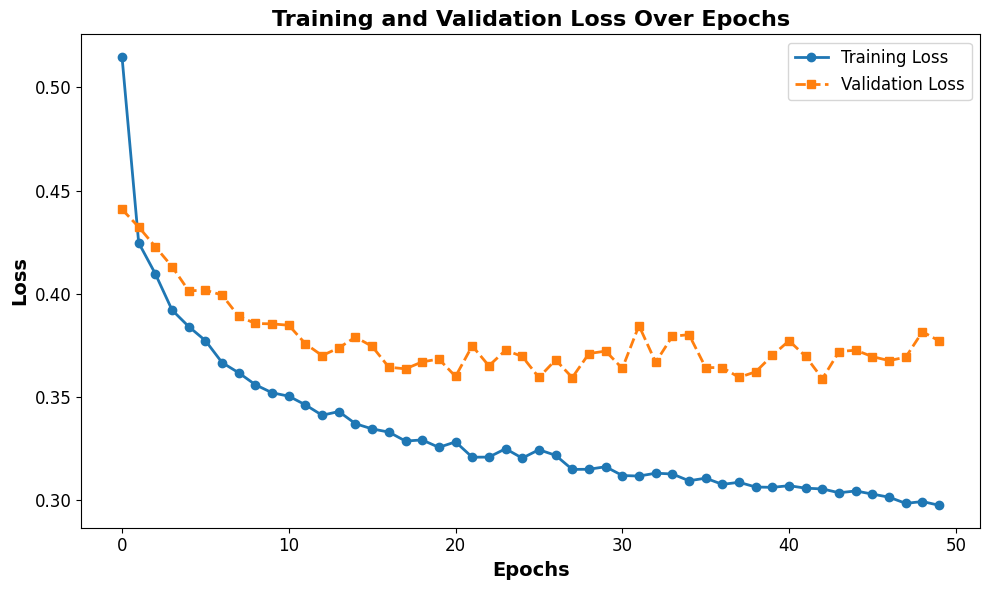

In [19]:

import matplotlib.pyplot as plt

def plot_losses(train_losses, validation_losses):
    # Convert validation_losses to CPU and detach before plotting
    validation_losses = [v.cpu().detach().numpy() for v in validation_losses]

    # Set the figure size and style
    plt.figure(figsize=(10, 6))

    # Plot training loss with markers
    plt.plot(train_losses, label='Training Loss', color='tab:blue', marker='o', markersize=6, linestyle='-', linewidth=2)

    # Plot validation loss with markers and different style
    plt.plot(validation_losses, label='Validation Loss', color='tab:orange', marker='s', markersize=6, linestyle='--', linewidth=2)

    # Add labels, title, and legend with improved styles
    plt.xlabel('Epochs', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=14, fontweight='bold')
    plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontweight='bold')

    # Display the legend with adjusted positioning
    plt.legend(loc='upper right', fontsize=12)

    # Adjust x and y ticks for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_losses(train_losses, val_losses)

In [20]:
# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for ts_values, ts_indicators, ts_time, static, labels in val_loader:
        ts_values,ts_indicators,ts_time, static, labels = ts_values.to(device), ts_indicators.to(device),ts_time.to(device), static.to(device), labels.to(device)
        outputs = model(ts_values, ts_indicators,ts_time, static)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 84.15%


In [21]:
def evaluate_model(model, data_loader, device):
    """
    Evaluates the model on the given data loader and calculates evaluation metrics.

    Args:
        model (torch.nn.Module): Trained model.
        data_loader (torch.utils.data.DataLoader): Data loader for validation/test set.
        device (torch.device): Device to perform computation on (CPU/GPU).

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for ts_values, ts_indicators, ts_time, static, labels in data_loader:
            # Move data to device
            ts_values,ts_indicators, ts_time, static, labels = ts_values.to(device), ts_indicators.to(device), ts_time.to(device), static.to(device), labels.to(device)

            # Get model predictions
            outputs = model(ts_values, ts_indicators, ts_time, static)  # Raw logits
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
            predictions = torch.argmax(outputs, dim=1)  # Predicted class labels

            # Collect predictions and ground truth
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_prob.extend(probabilities.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    roc_auc = roc_auc_score(y_true, y_prob)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
    }

Evaluate performance on all splits
- Save data in the same format as baseline models.

In [22]:
import time as time


def train(model, train_loader, val_loader, num_epochs = 100):
  model.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

  # Training loop
  train_losses = []
  val_losses = []
  AUC_scores = []
  times = []

  for epoch in range(num_epochs):  # Adjust epochs as needed
      start_time = time.time()
      model.train()
      loss_train = 0
      for ts_values, ts_indicators, ts_time, static, labels in train_loader:
          ts_values,ts_indicators, ts_time , static, labels = ts_values.to(device), ts_indicators.to(device), ts_time.to(device), static.to(device), labels.to(device)

          # Forward pass
          outputs = model(ts_values, ts_indicators, ts_time, static)
          loss = criterion(outputs, labels.long())

          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
          optimizer.step()

          loss_train += loss.item()

      train_losses.append(loss_train/len(train_loader))

      # validation loss
      model.eval().to(device)
      labels_list = torch.LongTensor([]).to(device)
      predictions_list = torch.FloatTensor([]).to(device)
      with torch.no_grad():
          for ts_values, ts_indicators, ts_time, static, labels in val_loader:
              ts_values,ts_indicators, ts_time, static, labels = ts_values.to(device), ts_indicators.to(device), ts_time.to(device), static.to(device), labels.to(device).long()
              labels_list = torch.cat((labels_list, labels), dim=0)
              predicition = model(ts_values, ts_indicators, ts_time, static)
              predictions_list = torch.cat((predictions_list, predicition), dim=0)

          probs = torch.nn.functional.softmax(predictions_list, dim=1)
          auc_score = roc_auc_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
          aupr_score = average_precision_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
          accuracy = accuracy_score(labels_list.cpu().numpy(), (probs[:, 1] >= 0.5).cpu().numpy())
          AUC_scores.append(auc_score)

      val_loss = criterion(predictions_list, labels_list)
      val_losses.append(val_loss)
      end_time = time.time()
      delta = end_time-start_time
      times.append(delta)

      if epoch%20==0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, AUC: {auc_score:.4f}, AUPR: {aupr_score:.4f}, Accuracy: {accuracy:.4f}, Time: {delta}")

  return model, train_losses, val_losses, AUC_scores, times

def test(model, test_loader):
    model.eval().to(device)  # Set model to evaluation mode

    # Loss and metrics
    criterion = nn.CrossEntropyLoss()
    test_losses = []
    labels_list = torch.LongTensor([]).to(device)
    predictions_list = torch.FloatTensor([]).to(device)

    with torch.no_grad():
        loss_test = 0
        for ts_values, ts_indicators, ts_time, static, labels in test_loader:
            # Move data to device
            ts_values, ts_indicators, ts_time, static, labels = (
                ts_values.to(device),
                ts_indicators.to(device),
                ts_time.to(device),
                static.to(device),
                labels.to(device).long(),
            )

            # Forward pass
            predictions = model(ts_values, ts_indicators, ts_time, static)
            loss = criterion(predictions, labels)

            # Accumulate test loss
            loss_test += loss.item()

            # Collect labels and predictions for metrics
            labels_list = torch.cat((labels_list, labels), dim=0)
            predictions_list = torch.cat((predictions_list, predictions), dim=0)

        # Compute average test loss
        test_losses.append(loss_test / len(test_loader))

        # Compute probabilities for metrics
        probs = torch.nn.functional.softmax(predictions_list, dim=1)
        auc_score = roc_auc_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        aupr_score = average_precision_score(labels_list.cpu().numpy(), probs[:, 1].cpu().numpy())
        predicted_labels = (probs[:, 1] >= 0.5).cpu().numpy().astype(int)
        accuracy = accuracy_score(labels_list.cpu().numpy(), predicted_labels)

    # Print test results
    print(f"Test Loss: {test_losses[-1]:.4f}, AUC: {auc_score:.4f}, AUPR: {aupr_score:.4f}, Accuracy: {accuracy:.4f}")

    return test_losses, auc_score, aupr_score, accuracy


In [23]:
import pandas as pd
import json

# empty dataframe for each split
training_log = pd.DataFrame(columns=["epoch",	"train_loss",	"val_loss",	"auc_score", "time"])
test_results = {
    "test_loss": 0,
    "accuracy": 0,
    "AUPRC": 0,
    "AUROC": 0,
}



splits = range(1, 6)

#### Loop over splits. Collect and save results

In [24]:
save_path = project_dir + f"/results/SMART_M_timed/"

for split in splits:

  # Load data
  train_data = np.load(f'/content/drive/MyDrive/ssm_ehr/datasets/split_{split}/train_physionet2012_{split}.npy', allow_pickle=True)
  test_data = np.load(f'/content/drive/MyDrive/ssm_ehr/datasets/split_{split}/test_physionet2012_{split}.npy', allow_pickle=True)
  val_data = np.load(f'/content/drive/MyDrive/ssm_ehr/datasets/split_{split}/validation_physionet2012_{split}.npy', allow_pickle=True)

  train_dataset = ICUTimeSeriesDataset(train_data)
  val_dataset = ICUTimeSeriesDataset(val_data)
  test_dataset = ICUTimeSeriesDataset(test_data)

  # Dataloader
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)


  # Reinstantiate a model after each split

  model = MoEMambaAttentionClassifier(
    ts_feature_dim=37,
    static_feature_dim=8,
    hidden_dim=16,
    num_classes=2
  )



  # Training loop
  model, train_losses, val_losses, AUC_scores, times = train(model, train_loader, val_loader, num_epochs = 100)

  training_log["epoch"]=[i for i in range(1, 101)]
  # Convert CUDA tensors to numpy-compatible values
  training_log["epoch"] = [i for i in range(1, 101)]
  training_log["train_loss"] = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
  training_log["val_loss"] = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in val_losses]
  training_log["auc_score"] = [auc.cpu().item() if torch.is_tensor(auc) else auc for auc in AUC_scores]
  training_log["time"] = [t.cpu().item() if torch.is_tensor(t) else t for t in times]


  # Testing

  test_losses, auc_score, aupr_score, accuracy = test(model, test_loader)
  test_results["test_loss"] = test_losses.cpu().item() if torch.is_tensor(test_losses) else test_losses
  test_results["accuracy"] = accuracy.cpu().item() if torch.is_tensor(accuracy) else accuracy
  test_results["AUPRC"] = aupr_score.cpu().item() if torch.is_tensor(aupr_score) else aupr_score
  test_results["AUROC"] = auc_score.cpu().item() if torch.is_tensor(auc_score) else auc_score

  # Save results

  # UNCOMMENT BELOW IF INTENDING TO SAVE RESULTS

  # train_fp = save_path+f"split_{split}/training_log.csv"
  # training_log.to_csv(train_fp, index=False)

  # test_fp = save_path+f"split_{split}/test_results.json"
  # json_results = json.dumps(test_results, indent=4)
  # with open(test_fp, 'w') as file:
  #   file.write(json_results)

  print(f"Successfully saved data fromm split: {split}")






/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch [1/100], Train Loss: 0.5299, Val Loss: 0.4397, AUC: 0.5560, AUPR: 0.1994, Accuracy: 0.8390, Time: 5.978167295455933
Epoch [21/100], Train Loss: 0.3278, Val Loss: 0.3562, AUC: 0.8145, AUPR: 0.4510, Accuracy: 0.8432, Time: 5.840825080871582
Epoch [41/100], Train Loss: 0.3066, Val Loss: 0.3584, AUC: 0.8242, AUPR: 0.4593, Accuracy: 0.8532, Time: 5.858995199203491
Epoch [61/100], Train Loss: 0.2880, Val Loss: 0.3510, AUC: 0.8256, AUPR: 0.4711, Accuracy: 0.8524, Time: 5.783873081207275
Epoch [81/100], Train Loss: 0.2737, Val Loss: 0.3760, AUC: 0.8178, AUPR: 0.4750, Accuracy: 0.8474, Time: 5.856794118881226
Test Loss: 0.3251, AUC: 0.8225, AUPR: 0.4844, Accuracy: 0.8674
Successfully saved data fromm split: 1


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch [1/100], Train Loss: 0.6024, Val Loss: 0.4775, AUC: 0.6199, AUPR: 0.2352, Accuracy: 0.8449, Time: 6.095867872238159
Epoch [21/100], Train Loss: 0.3352, Val Loss: 0.3364, AUC: 0.8232, AUPR: 0.5250, Accuracy: 0.8582, Time: 5.819227695465088
Epoch [41/100], Train Loss: 0.3167, Val Loss: 0.3292, AUC: 0.8310, AUPR: 0.5290, Accuracy: 0.8641, Time: 5.90046238899231
Epoch [61/100], Train Loss: 0.3013, Val Loss: 0.3244, AUC: 0.8364, AUPR: 0.5339, Accuracy: 0.8607, Time: 5.85589075088501
Epoch [81/100], Train Loss: 0.2850, Val Loss: 0.3309, AUC: 0.8309, AUPR: 0.5063, Accuracy: 0.8682, Time: 5.879032611846924
Test Loss: 0.3170, AUC: 0.8221, AUPR: 0.4378, Accuracy: 0.8716
Successfully saved data fromm split: 2


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch [1/100], Train Loss: 0.5050, Val Loss: 0.4525, AUC: 0.5009, AUPR: 0.1526, Accuracy: 0.8524, Time: 5.996852397918701
Epoch [21/100], Train Loss: 0.3344, Val Loss: 0.3250, AUC: 0.8345, AUPR: 0.4749, Accuracy: 0.8557, Time: 5.6079277992248535
Epoch [41/100], Train Loss: 0.3138, Val Loss: 0.3174, AUC: 0.8448, AUPR: 0.4923, Accuracy: 0.8657, Time: 5.915979385375977
Epoch [61/100], Train Loss: 0.3013, Val Loss: 0.3207, AUC: 0.8404, AUPR: 0.4874, Accuracy: 0.8649, Time: 5.880053758621216
Epoch [81/100], Train Loss: 0.2844, Val Loss: 0.3173, AUC: 0.8451, AUPR: 0.4931, Accuracy: 0.8666, Time: 5.877262115478516
Test Loss: 0.3299, AUC: 0.8297, AUPR: 0.4736, Accuracy: 0.8607
Successfully saved data fromm split: 3


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch [1/100], Train Loss: 0.5208, Val Loss: 0.4056, AUC: 0.5838, AUPR: 0.1926, Accuracy: 0.8607, Time: 6.037936449050903
Epoch [21/100], Train Loss: 0.3279, Val Loss: 0.3372, AUC: 0.7942, AUPR: 0.4260, Accuracy: 0.8607, Time: 5.746225118637085
Epoch [41/100], Train Loss: 0.3082, Val Loss: 0.3297, AUC: 0.8032, AUPR: 0.4564, Accuracy: 0.8766, Time: 5.697206258773804
Epoch [61/100], Train Loss: 0.2910, Val Loss: 0.3335, AUC: 0.8045, AUPR: 0.4421, Accuracy: 0.8716, Time: 5.905679225921631
Epoch [81/100], Train Loss: 0.2770, Val Loss: 0.3322, AUC: 0.8040, AUPR: 0.4257, Accuracy: 0.8682, Time: 5.832646369934082
Test Loss: 0.3520, AUC: 0.8112, AUPR: 0.4590, Accuracy: 0.8599
Successfully saved data fromm split: 4


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch [1/100], Train Loss: 0.8874, Val Loss: 0.6986, AUC: 0.6303, AUPR: 0.2099, Accuracy: 0.4270, Time: 5.793361186981201
Epoch [21/100], Train Loss: 0.3429, Val Loss: 0.3131, AUC: 0.8298, AUPR: 0.4540, Accuracy: 0.8799, Time: 6.051904201507568


KeyboardInterrupt: 